# CELLS SPIKES GENERATION

In [1]:
# Generating spikes of MFs and GrCs using the EDLUT simulator 

In [2]:
# Importing libraries
from pyedlut import simulation_wrapper as pyedlut
import numpy as np
import os
import sys

In [3]:
################### PARAMETERS ###########################
######### 01_anatomical_model_generation #################

seed = 0 # seed for the generation of cells positions

########## 02_input_patterns_generation ##################

## Spatial correlation between MFs 
sigma = 5 

## List of MF active fractions that will be used 
f_mf = np.linspace(.05, 0.95, 10)
f_mf = [f_mf[5]]
## Number of patterns to be simulate for each
## MF active fraction 
num_patterns = 640

############## 03_simulations ############################

## Poisson generator seed that will be used for MFs spikes 
## Initializing it to the same seed as for cell posisions
poisson_seed = seed

## List of noises fractions to be introduced in the set 
## of MFs patterns
noises = [0.0]

## Number of presentations/samples for each pattern
## Important parameter when noise != 0.0
n_seeds = 1

## Duration of each simulated pattern 
duration_pattern = 0.080 ## 80 ms

## Interval used to count spikes 
## The first 10 ms will be discarded
interval = 0.070 ## 70 ms


###### Synaptic weights ######

## Total synaptic weight that reaches each GrC from MFs
mf_grc_w = 4.00

## Number of MFs connected to each GrC
## Should not be changed
n_mf_grc = 4 

## List of synaptic weights to simulate from MF to GoC
mf_goc_weights = [0.10]

## List of synaptic weights to simulate from GrC to GoC
grc_goc_weights = [0.015]

# Inhibitory weight in GoC to GrC synapsis
## Should not be to larger or the simulator crashes 
goc_grc_w = 0.50 

###########################################################

In [4]:
## Function to count the number of spikes per cell and per pattern (step)

def spikes_count(oi, ot, t_step, t_lower):

    ## receives cells spiking times (ot) and their indexes (oi)
    ## receives duration of the pattern (t_step) and the time discarded from the pattern (t_lower)
    ## retrieves spikes count per pattern and per cell
        
    total_rows = n_inputs + n_hidden_neurons + n_outputs # neurons number 
    total_columns = int(total_simulation_time / t_step) # intervals number  
    spikes_count = np.zeros((total_rows, total_columns))

    for i in range(len(oi)):
        col = int(ot[i]//t_step)
        t = ot[i] - col*t_step

        if (t > t_lower):
            spikes_count[oi[i]][col] += 1

    return spikes_count

In [5]:
## Reading structure data 
sys.path.insert(1, '../data/structure')
DATA_DIR = '../data/structure'
SEED_DATA_DIR = os.path.join(DATA_DIR, 'seed' + str(seed))

## For each noise from list of noises to be applied
for noise in noises:
    
    ## For each GrC - GoC weight to be simulated 
    for grc_goc_w in grc_goc_weights:

        ## For each MF - GoC weight to be simulated
        for mf_goc_w in mf_goc_weights:
            
            ## For each MF active fraction 
            for elem in f_mf:

                ## Loading anatomical model information 
                with open(SEED_DATA_DIR + '/glos.npy', 'rb') as f:
                    glos = np.load(f)
                with open(SEED_DATA_DIR + '/grcs.npy', 'rb') as f:
                    grcs = np.load(f)
                with open(SEED_DATA_DIR + '/gocs.npy', 'rb') as f:
                    gocs = np.load(f)    
                with open(SEED_DATA_DIR + '/conn_mat_glos_to_grc.npy', 'rb') as f:
                    conn_mat_glos_to_grc = np.load(f)    
                with open(SEED_DATA_DIR + '/conn_mat_glos_to_goc.npy', 'rb') as f:
                    conn_mat_glos_to_goc = np.load(f)
                with open(SEED_DATA_DIR + '/conn_mat_grcs_to_goc.npy', 'rb') as f:
                    conn_mat_grcs_to_goc = np.load(f)
                with open(SEED_DATA_DIR + '/conn_mat_goc_to_grcs.npy', 'rb') as f:
                    conn_mat_goc_to_grcs = np.load(f) 


                ## Total active MF fraction of the simulation
                fraction = elem 

                ## Number of cells for each population
                n_inputs = glos.shape[0]
                n_hidden_neurons = grcs.shape[0]
                n_outputs = gocs.shape[0]

                ## Setting to 0 this synapses momentarily because we have to previously introduce noise in 
                ## the MF patterns
                mf_grc_w_0 = 0.00 

                ## Time steps in seconds 
                edlut_time_step = 5e-4
                
                ## Simulation time in seconds
                stop_simulation_at = num_patterns * duration_pattern
            
                # Defining LIF neuron parameters
                default_neuron_params = {
                    'c_m': 250.0,
                    'e_exc': 0.0,
                    'e_inh': -85.0,
                    'e_leak': -65.0,
                    'g_leak': 25.0,
                    'tau_exc': 5.0,
                    'tau_inh': 10.0,
                    'tau_nmda': 20.0,
                    'tau_ref': 1.0,
                    'v_thr': -40.0,
                    'int_meth': None,
                }


                poisson_generator_params = {
                    'frequency': 50.0,
                }

                hidden_neuron_params = { 
                    **default_neuron_params,
                    'c_m': 2.0,
                    'e_exc': 0.0,
                    'e_inh': -65.0,
                    'e_leak': -65.0,
                    'g_leak': 0.2,
                    'tau_exc': 0.5,
                    'tau_inh': 10.0,
                    'tau_nmda': 40.0,
                    'tau_ref': 1.5,
                    'v_thr': -40.0,   
                }

                # Parámetros de las GOC
                output_neuron_params = {
                    **default_neuron_params,        
                    'c_m': 50.0,
                    'g_leak': 10.0,
                    'v_thr': -50.0,
                } 

                # Parámetros de las sinapsis
                default_synapse_params = {
                    'weight': 0.006,    #Initial weight
                    'max_weight': 0.020, #Max weight
                    'type': 0,
                    'delay': 0.001,
                    'wchange': -1,
                    'trigger_wchange': -1,
                }




                ####################### SIMULATION 0 ##############################################################################################
                ## In this initial simulation, only MFs spikes will be generated using the raw patterns without noise
                
                ## Loading input patterns
                sys.path.insert(1, '../data/input_patterns')
                with open('../data/input_patterns/seed'+ str(seed) + '/mf_activity_f_mf_' + str(fraction) + '_s_' + str(sigma) + '.npy', 'rb') as f:       
                    mf_activity = np.load(f)

                ## Preparing activity dataset 
                mf_activity = mf_activity[0].T
                mf_activity = mf_activity[:,:num_patterns] ## taking only the number of patterns we want to simulate

                
                ## Defining binary input patterns
                input_patterns = np.zeros((n_inputs, num_patterns))                
                input_patterns = np.tile(mf_activity, reps = 1)

                ## Declaring the simulation object
                simulation = pyedlut.PySimulation_API()
                ## Initializing Poisson generator seed 
                simulation.SetRandomGeneratorSeed(poisson_seed)

                ## Defining the integration method
                integration_method = pyedlut.PyModelDescription(model_name='RK4', params_dict={'step': edlut_time_step})
                default_neuron_params['int_meth'] = integration_method
                hidden_neuron_params['int_meth'] = integration_method

                ## Defining synapsis
                mf_grc_synapse_params = {**default_synapse_params,'weight': mf_grc_w_0/n_mf_grc,'max_weight': mf_grc_w_0/n_mf_grc, 'type': 0}

                ## Creating neuron layers
                
                # MFs layer
                input_poisson_generator_layer = simulation.AddNeuronLayer(
                    num_neurons = n_inputs,
                    model_name = 'PoissonGeneratorDeviceVector',
                    param_dict = poisson_generator_params,
                    log_activity = False,
                    output_activity = True
                )

                # GrCs layer
                hidden_layer = simulation.AddNeuronLayer(
                    num_neurons = n_hidden_neurons,
                    model_name = 'LIFTimeDrivenModel',
                    param_dict = hidden_neuron_params,
                    log_activity = False,
                    output_activity = False
                )

                #################### Connections from MF to GRC ################################

                sources2 = []
                hidden2 = []

                for i in range(conn_mat_glos_to_grc.shape[1]): 
                    srcs = np.where(conn_mat_glos_to_grc[:,i] == 1)[0].tolist()
                    sources2.append(srcs)
                    hid = i + n_inputs
                    hidden2.append([hid]*len(srcs))


                sources = []
                hidden = []

                ## Saving the indexes of all the MFs connected to each GrC
                for sublist in sources2:
                    for item in sublist:
                        sources.append(item)

                for sublist in hidden2:
                    for item in sublist:
                        hidden.append(item)

                # Defining MF -> GrC excitatory synapsis 
                weights = simulation.AddSynapticLayer(
                source_list = sources,
                target_list = hidden,
                param_dict = mf_grc_synapse_params,
                )    
                
                ## Initializing simulation
                simulation.Initialize()

                ## Setting PoissonGeneratorDeviceVector
                ## Firing rate frequency for MFs will be 50.0 Hz

                for i in range(n_inputs):

                    poisson_params = {'frequency': 50.0 * input_patterns[i, 0]} # noise for MFs in the inner cube 
                    simulation.SetSpecificNeuronParams(input_poisson_generator_layer[i], poisson_params)

                ## Running the simulation step-by-step (pattern by pattern)

                total_simulation_time = stop_simulation_at
                simulation_bin = duration_pattern

                j = 1
                for sim_time in np.arange(0.0 + simulation_bin, total_simulation_time + simulation_bin - 0.000001, simulation_bin):

                    simulation.RunSimulation(sim_time)

                    if j < (num_patterns):

                        # Updating all poissons every timebin
                        for i in range(n_inputs):
                                poisson_params = {'frequency': 50.0 * input_patterns[i,j]}
                                simulation.SetSpecificNeuronParams(input_poisson_generator_layer[i], poisson_params)

                    j += 1

                # Retrieving output spike activity
                output_times, output_index = simulation.GetSpikeActivity()
                ot0 = np.array(output_times) ## spikes times
                oi0 = np.array(output_index) ## spikes indexes

                ## Initializing noise seed
                seed_noise = 0

                for k in range(n_seeds):
                    
                    ####################### SIMULATION K ##############################################################################################
                    
                    ## Now that the original MFs spikes have been generated, 
                    ## new spikes trains will be generated for each pattern
                
                    with open('../data/input_patterns/seed'+ str(seed) + '/mf_activity_f_mf_' + str(fraction) + '_s_' + str(sigma) + '.npy', 'rb') as f:       
                        mf_activity = np.load(f)

                    ## Preparing activity dataset 
                    mf_activity = mf_activity[0].T
                    mf_activity = mf_activity[:,:num_patterns] ## taking only the number of patterns we want to simulate

                    ## Input patterns (binary vectors)
                    input_patterns = np.zeros((n_inputs, num_patterns))

                    ## Declaring the simulation object
                    simulation = pyedlut.PySimulation_API()
                    ## Updating the poisson seed (very important in order to have new spikes trains)
                    simulation.SetRandomGeneratorSeed(k + poisson_seed + 1)

                    ## Defining the integration method
                    integration_method = pyedlut.PyModelDescription(model_name='RK4', params_dict={'step': edlut_time_step})
                    default_neuron_params['int_meth'] = integration_method
                    hidden_neuron_params['int_meth'] = integration_method

                    ## Defining synapsis
                    mf_grc_synapse_params = {**default_synapse_params,'weight': mf_grc_w_0/n_mf_grc,'max_weight': mf_grc_w_0/n_mf_grc, 'type': 0}

                    ## Creating neuron layers

                    # MFs layer
                    input_poisson_generator_layer = simulation.AddNeuronLayer(
                        num_neurons = n_inputs,
                        model_name = 'PoissonGeneratorDeviceVector',
                        param_dict = poisson_generator_params,
                        log_activity = False,
                        output_activity = True
                    )    

                    # GRCs layer
                    hidden_layer = simulation.AddNeuronLayer(
                        num_neurons = n_hidden_neurons,
                        model_name = 'LIFTimeDrivenModel',
                        param_dict = hidden_neuron_params,
                        log_activity = False,
                        output_activity = False
                    )


                    #################### Connections from MF to GRC ################################

                    sources2 = []
                    hidden2 = []

                    for i in range(conn_mat_glos_to_grc.shape[1]): 
                        srcs = np.where(conn_mat_glos_to_grc[:,i] == 1)[0].tolist()
                        sources2.append(srcs)
                        hid = i + n_inputs
                        hidden2.append([hid]*len(srcs))


                    sources = []
                    hidden = []

                    ## Saving the indexes of all the MFs connected to each GrC
                    for sublist in sources2:
                        for item in sublist:
                            sources.append(item)

                    for sublist in hidden2:
                        for item in sublist:
                            hidden.append(item)

                    ## MF -> GrC excitatory synapsis 
                    weights = simulation.AddSynapticLayer(
                    source_list = sources,
                    target_list = hidden,
                    param_dict = mf_grc_synapse_params,
                    )    

                    
                    ## Initializing simulation
                    simulation.Initialize()

                    # Activating all MFs in order to generate spikes in all of them
                    for i in range(n_inputs):
                            input_patterns[i,:] = 1.0


                    ## Setting PoissonGeneratorDeviceVector
                    ## Firing rate frequency for MFs will be 50.0 Hz

                    for i in range(n_inputs):
                            
                        poisson_params = {'frequency': 50.0 * input_patterns[i, 0]} # noise for MFs in the inner cube 
                        simulation.SetSpecificNeuronParams(input_poisson_generator_layer[i], poisson_params)

                    # Running the simulation step-by-step (pattern by pattern)

                    total_simulation_time = stop_simulation_at
                    simulation_bin = duration_pattern

                    j = 1
                    for sim_time in np.arange(0.0 + simulation_bin, total_simulation_time + simulation_bin - 0.000001, simulation_bin):

                        simulation.RunSimulation(sim_time)

                        if j < (num_patterns):

                            # Updating all poissons every timebin
                            for i in range(n_inputs):
                                poisson_params = {'frequency': 50.0 * input_patterns[i,j]}
                                simulation.SetSpecificNeuronParams(input_poisson_generator_layer[i], poisson_params)

                        j += 1


                    
                    # Retrieving output spike activity
                    output_times, output_index = simulation.GetSpikeActivity()
                    ot_k = np.array(output_times)
                    oi_k = np.array(output_index)


                    
                    
                    #########################################################################################
                    ### MERGING OF S0 AND S_K ###############################################################
                    #########################################################################################

                    ## Now, given the chosen noise percentage, the activity of noisy MFs will be replace
                    ## from their original spikes to the ones generated in the new spikes trains
                    ## The rest of connections will also be generated

                    print("")
                    print('Sigma: ' + str(sigma))
                    print('f_mf: ' + str(fraction))
                    print('MF - GOC weight: ' + str(mf_goc_w))
                    print('GRC - GOC weight: ' + str(grc_goc_w))
                    print("")


                    ## Generating directories for spikes count
                    os.makedirs('../data/spikes/seed' + str(seed) 
                                + '/sigma_' + str(sigma) 
                                + '/noise_' + str(noise)
                                + '/grc'
                                + '/mf_grc_' + str(mf_grc_w)
                                + '/mf_goc_w_' + str(mf_goc_w)
                                + '/goc_grc_w_' + str(goc_grc_w)
                                + '/grc_goc_w_' + str(grc_goc_w)
                                + '/f_mf_' + str(fraction) , exist_ok=True)

                    os.makedirs('../data/spikes/seed' + str(seed) 
                                + '/sigma_' + str(sigma) 
                                + '/noise_' + str(noise)
                                + '/mf'
                                + '/f_mf_' + str(fraction) , exist_ok=True)


                    ## Declaring the simulation object
                    simulation = pyedlut.PySimulation_API()

                    ## Defining the integration method
                    integration_method = pyedlut.PyModelDescription(model_name='RK4', params_dict={'step': edlut_time_step})
                    default_neuron_params['int_meth'] = integration_method
                    hidden_neuron_params['int_meth'] = integration_method
                    output_neuron_params['int_meth'] = integration_method

                    ## Defining the synapses parameters
                    mf_grc_synapse_params = {**default_synapse_params,'weight': mf_grc_w/n_mf_grc,'max_weight': mf_grc_w/n_mf_grc, 'type': 0}
                    mf_goc_synapse_params = {**default_synapse_params,'weight': mf_goc_w,'max_weight': mf_goc_w, 'type': 0}
                    grc_goc_synapse_params = {**default_synapse_params,'weight': grc_goc_w,'max_weight': grc_goc_w, 'type': 0}
                    goc_grc_synapse_params = {**default_synapse_params,'weight': goc_grc_w,'max_weight': goc_grc_w, 'type': 1}

                    ## Creating neuron layers 

                    # MFs layer
                    input_poisson_generator_layer = simulation.AddNeuronLayer(
                        num_neurons = n_inputs,
                        model_name = 'InputSpikeNeuronModel',
                        param_dict = {},
                        log_activity = False,
                        output_activity = True
                    )

                    # GRCs layer
                    hidden_layer = simulation.AddNeuronLayer(
                        num_neurons = n_hidden_neurons,
                        model_name = 'LIFTimeDrivenModel',
                        param_dict = hidden_neuron_params,
                        log_activity = False,
                        output_activity = True
                    )

                    # GoCs layer
                    output_layer = simulation.AddNeuronLayer(
                        num_neurons = n_outputs,
                        model_name = 'LIFTimeDrivenModel',
                        param_dict = output_neuron_params,
                        log_activity = False,
                        output_activity = True
                    )

                    #################### Connections from MF to GRC ################################

                    sources2 = []
                    hidden2 = []

                    for i in range(conn_mat_glos_to_grc.shape[1]): 
                        srcs = np.where(conn_mat_glos_to_grc[:,i] == 1)[0].tolist()
                        sources2.append(srcs)
                        hid = i + n_inputs
                        hidden2.append([hid]*len(srcs))


                    sources = []
                    hidden = []

                    ## Saving the indexes of all the MFs connected to each GrC
                    for sublist in sources2:
                        for item in sublist:
                            sources.append(item)

                    for sublist in hidden2:
                        for item in sublist:
                            hidden.append(item)

                    # MF -> GrC excitatory synapsis 
                    weights = simulation.AddSynapticLayer(
                    source_list = sources,
                    target_list = hidden,
                    param_dict = mf_grc_synapse_params,
                    )    

                    ######################## Connections from MF to GoC ###############################

                    sources2 = []
                    targets2 = []

                    for i in range(conn_mat_glos_to_goc.shape[1]): 
                        srcs = np.where(conn_mat_glos_to_goc[:,i] == 1)[0].tolist()
                        sources2.append(srcs)
                        tar = i + n_inputs + n_hidden_neurons
                        targets2.append([tar]*len(srcs))

                    sources = []
                    targets = []

                    for sublist in sources2:
                        for item in sublist:
                            sources.append(item)    

                    for sublist in targets2:
                        for item in sublist:
                            targets.append(item)


                    # MF -> GOC excitatory synapsis 
                    _ = simulation.AddSynapticLayer(
                    source_list = sources,
                    target_list = targets,
                    param_dict = mf_goc_synapse_params,
                    )

                    #################### Connections from to GrC to GoC #################################

                    hidden2 = []
                    targets2 = []

                    for i in range(conn_mat_grcs_to_goc.shape[1]): 
                        hids = np.where(conn_mat_grcs_to_goc[:,i] == 1)[0].tolist()
                        hidden2.append([hid + n_inputs for hid in hids])
                        tar = i + n_inputs + n_hidden_neurons
                        targets2.append([tar]*len(hids))

                    hiddens = []
                    targets = []

                    for sublist in hidden2:
                        for item in sublist:
                            hiddens.append(item)    

                    for sublist in targets2:
                        for item in sublist:
                            targets.append(item)    

                    # GrC -> GOC excitatory synapsis 
                    _ = simulation.AddSynapticLayer(
                    source_list = hiddens,
                    target_list = targets,
                    param_dict = grc_goc_synapse_params,
                    )

                    #################### Connections from to GoC to GrC ##################################

                    hidden2 = []
                    targets2 = []

                    for i in range(conn_mat_goc_to_grcs.shape[1]): 
                        hids = np.where(conn_mat_goc_to_grcs[:,i] == 1)[0].tolist()
                        hidden2.append([hid + n_inputs for hid in hids])
                        tar = i + n_inputs + n_hidden_neurons
                        targets2.append([tar]*len(hids))

                    hiddens = []
                    targets = []

                    for sublist in hidden2:
                        for item in sublist:
                            hiddens.append(item)    

                    for sublist in targets2:
                        for item in sublist:
                            targets.append(item)    

                    # GoC -> GrC inhibitory synapsis 
                    _ = simulation.AddSynapticLayer(
                    source_list = targets,
                    target_list = hiddens,
                    param_dict = goc_grc_synapse_params,
                    )
                    
                    ## Initializing simulation
                    simulation.Initialize()

                    dt = duration_pattern
                    np.random.seed(seed_noise)    
                    ## Initial time (first pattern)
                    time = 0.0 
                    
                    ## Number of possible noisy inputs
                    n_noise = round(noise*n_inputs)
                    
                    ## Indexes of possible noisy inputs
                    noise_indexes = np.random.choice(range(n_inputs), n_noise, replace = False) ## indexes of the mfs that we will flip their activity
                    
                    ## Number of noisy inputs whose activity will be changed 
                    ## given the MF active fraction of the simulation
                    n_active = round(fraction*len(noise_indexes))
                    
                    ## Indexes of noisy MFs that will be activitated
                    active_indexes = np.random.choice(noise_indexes, n_active, replace = False)
                    
                    # Deleting the activity of the noisy inputs from the original spikes vectors
                    tim = (ot0>=time) * (ot0<=(time+dt)) 
                    ot_new0 = ot0[tim]
                    oi_new0 = oi0[tim]
                    for elemento in noise_indexes: 
                        positions = list(np.where(oi_new0 == elemento)[0])
                        if positions:
                            oi_new0 = np.delete(oi_new0, positions)
                            ot_new0 = np.delete(ot_new0, positions)
                    
                    ## Activating the chosen noisy inputs with the activity of the new spikes trains
                    tim = (ot_k>=time) * (ot_k<=(time+dt)) 
                    ot_newk = ot_k[tim]
                    oi_newk = oi_k[tim]
                    for elemento in active_indexes: 
                        positions = list(np.where(oi_k[tim] == elemento)[0])
                        if positions:
                            oi_new0 = np.concatenate((oi_new0, oi_newk[positions]))
                            ot_new0 = np.concatenate((ot_new0, ot_newk[positions]))


                    ## Adding external spike activity (times and neuron indexes)
                    simulation.AddExternalSpikeActivity(ot_new0, oi_new0)

                    ## Running the simulation step-by-step (pattern by pattern)

                    total_simulation_time = stop_simulation_at
                    simulation_bin = duration_pattern

                    j = 1
                    for sim_time in np.arange(0.0 + simulation_bin, total_simulation_time + simulation_bin - 0.000001, simulation_bin):

                        simulation.RunSimulation(sim_time)

                        if j < (num_patterns):

                            seed_noise += 1    
                            np.random.seed(seed_noise)

                            ## Number of possible noisy input
                            n_noise = round(noise*n_inputs) 
                            
                            ## Indexes of possible noisy inputs
                            noise_indexes = np.random.choice(range(n_inputs), n_noise, replace = False) ## indexes of the mfs that we will flip their activity
                            
                            ## Number of noisy inputs whose activity will be changed 
                            ## given the MF active fraction of the simulation
                            n_active = round(fraction*len(noise_indexes))
                            
                            ## Indexes of noisy MFs that will be activitated
                            active_indexes = np.random.choice(noise_indexes, n_active, replace = False)

                            ## Deleting the activity of the noisy inputs from the original spikes vectors
                            tim = (ot0>=sim_time) * (ot0<=(sim_time+dt)) 
                            ot_new0 = ot0[tim]
                            oi_new0 = oi0[tim]

                            for elemento in noise_indexes: 
                                positions = list(np.where(oi_new0 == elemento)[0])
                                if positions:
                                    oi_new0 = np.delete(oi_new0, positions)
                                    ot_new0 = np.delete(ot_new0, positions)

                            ## Activating the chosen noisy inputs with the activity of the new spikes trains
                            tim = (ot_k>=sim_time) * (ot_k<=(sim_time+dt)) 
                            ot_newk = ot_k[tim]
                            oi_newk = oi_k[tim]

                            for elemento in active_indexes: 

                                positions = list(np.where(oi_k[tim] == elemento)[0])

                                if positions:
                                    oi_new0 = np.concatenate((oi_new0, oi_newk[positions]))
                                    ot_new0 = np.concatenate((ot_new0, ot_newk[positions]))

                            # Adding external spike activity (times and neuron indexes)
                            simulation.AddExternalSpikeActivity(ot_new0, oi_new0)

                        j += 1


                    seed_noise += 1


                    # Retrieving output spike activity
                    output_times, output_index = simulation.GetSpikeActivity()
                    ot = np.array(output_times)
                    oi = np.array(output_index)

                    t_step = duration_pattern
                    t_lower = duration_pattern - interval
                    
                    # ## Counting number of spikes for each cell
                    # matrix = spikes_count(oi, ot, t_step, t_lower)

                    # ## Saving MF spikes
                    # np.savetxt('../data/spikes/seed' + str(seed) 
                    #         + '/sigma_' + str(sigma) 
                    #         + '/noise_' + str(noise)
                    #         + '/mf'
                    #         + '/f_mf_' + str(fraction) 
                    #         + '/i' + str(interval) + '_mf_s' + str(k) + '.csv', 
                    #         matrix[:n_inputs,:])

                    # ## Saving GRC spikes
                    # np.savetxt('../data/spikes/seed' + str(seed) 
                    #         + '/sigma_' + str(sigma) 
                    #         + '/noise_' + str(noise)
                    #         + '/grc'
                    #         + '/mf_grc_' + str(mf_grc_w) 
                    #         + '/mf_goc_w_' + str(mf_goc_w)
                    #         + '/goc_grc_w_' + str(goc_grc_w)
                    #         + '/grc_goc_w_' + str(grc_goc_w)
                    #         +'/f_mf_' + str(fraction) 
                    #         + '/i' + str(interval) + '_grc_s' + str(k) + '.csv', 
                    #            matrix[n_inputs:(n_inputs + n_hidden_neurons),:])

                    # del matrix, ot, oi, ot_k, oi_k
                




NEW SEED: 0
OpenMP support is enabled
NEW SEED: 1
OpenMP support is enabled

Sigma: 5
f_mf: 0.5499999999999999
MF - GOC weight: 0.1
GRC - GOC weight: 0.015

OpenMP support is enabled


In [8]:
import matplotlib.pyplot as plt

input_duration_patterns = np.ones(num_patterns)*duration_pattern

# se ordenan y se van sumando, acumulando
cumsum_input_duration_patterns = np.cumsum(input_duration_patterns)

# se pone un primer elemento 0 para que el tiempo comience en 0
cumsum_input_duration_patterns = np.insert(cumsum_input_duration_patterns, 0, 0)

def plot_spikes(t, dt):
    import matplotlib.transforms as mtransforms
    ## Receives cells spikes times and indexes, a dictionary with important parameters about the simulation
    ## and initial time to plot and the interval to plot
    
    ## Returns a figure plot
    
    
    plt.rcParams['figure.figsize'] = (10,3)
    plt.rcParams["savefig.facecolor"] = "white"
    ## Creating figure
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [10, 20, 6]})


    # fill_pattern = np.roll(np.repeat(show_pattern, 2), 1)
    
    # trans = mtransforms.blended_transform_factory(ax1.transData, ax1.transAxes)
    # ax1.fill_between(
    #     np.repeat(cumsum_input_duration_patterns[:-1], 2), 
    #     0, n_inputs/n_inputs, 
    #     where=fill_pattern,
    #     facecolor='green', alpha=0.5, transform=trans)


    ax1.set(ylabel='MF')

    ## Scattering the spikes of MFs
    tim = (ot>=t) * (ot<=(t+dt))
    if dt<=10.0:
        inp = (oi<=input_poisson_generator_layer[-1]) * ((oi%50)==0) 
        ax1.scatter(ot[inp*tim], oi[inp*tim], s=4.0, color='red')


    out = (oi> input_poisson_generator_layer[-1])*(oi<output_layer[0])* ((oi%50)==0)
    ax2.scatter(ot[out*tim], oi[out*tim], s=4.0, color='darkblue')
    ax2.axes.get_yaxis().set_visible(True)   
    ax2.set(ylabel='GRC')

    ## For GoCs
    ## Scaterring the spikes of GoCs
    out = (oi >= output_layer[0])
    ax3.scatter(ot[out*tim], oi[out*tim], s=4.0, color='green')
    ax3.axes.get_yaxis().set_visible(True)
    ax3.set(ylabel='GOC')
    ax3.set(xlabel = 'Time (s)')
    ax3.set_yticklabels([0, 0, 5])

    plt.xlim((t, t+dt))
    

/tmp/ipykernel_27245/434817909.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([0, 0, 5])


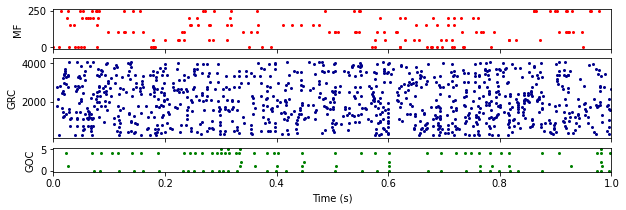

In [9]:
plot_spikes(0, 1)